In [ ]:
# matplotlib 한글 폰트 적용
# 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 설치 후 런타임 다시시작

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로딩

In [31]:
(train_image, train_label), (test_image, test_label) = keras.datasets.cifar10.load_data()

In [32]:
class_names = np.array(['비행기', '자동차', '새', '고양이', '사슴', '개', '개구리', '말', '배', '트럭'])

In [35]:
train_image.shape, train_label.shape
# (50000, 32, 32, 3): channel - 3: color

((50000, 32, 32, 3), (50000, 1))

In [36]:
train_label[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [34]:
np.unique(train_label)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

# 이미지 확인
- matplotlib을 이용해 N개의 이미지를 확인한다. 
    - 개수는 알아서 선택하세요.

In [6]:
print(train_image.shape,train_label.shape)
print(test_image.shape, test_label.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [9]:
# from sklearn.model_selection import train_test_split # 데이터가 numpy배열일 경우 그냥 train_test_split을 쓰면 알아서 셜플까지 해준다.
# train_image, val_image, train_label, y_val = train_test_split(train_image,
#                                                           train_label,
#                                                           test_size=0.2,
#                                                           stratify=train_label,
#                                                           random_state=0)
# train_image.shape, val_image.shape

((32000, 32, 32, 3), (8000, 32, 32, 3))

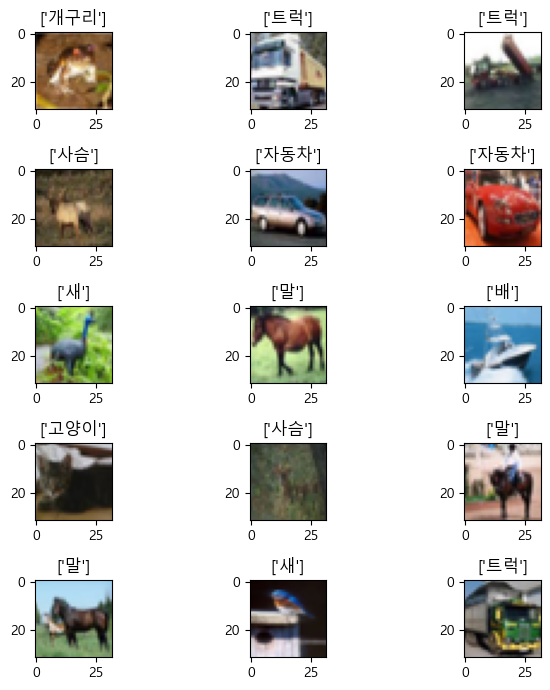

In [12]:
cnt = 15  # 확인할 이미지개수 (5배수)
plt.figure(figsize=(7,7))
for i in range(cnt):
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False
    plt.subplot(5, int(cnt/5), i+1) # 5행 _열
    plt.imshow(train_image[i], cmap='Greys')  # gray: 0-black, 255: white,  Greys: 0-white, 255-black
    label = class_names[train_label[i]]
    plt.title(label)

plt.tight_layout()
plt.show()

# 데이터 전처리
- X: 0 ~ 1 scaling
- y: onehot encoding

In [13]:
# input 전처리 => 0~1 정규화
X_train = train_image.astype('float32')/255.0
X_test = test_image.astype('float32')/255.0
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [15]:
print(train_image.min(), train_image.max())
print(X_train.min(), X_train.max())

0 255
0.0 1.0


In [16]:
#output 전처리 => OneHot Encoding
y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)

In [17]:
y_train.shape, y_test.shape

((50000, 10), (10000, 10))

# 하이퍼파라미터, 변수 정의

In [18]:
LEARNING_RATE = 0.001  # 학습률
N_EPOCH = 1         # 에폭수
N_BATCH = 1000         # 배치 사이즈

# Dataset 생성
- train/test set

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

# 모델 생성 및 컴파일
- CNN 모델을 이용해 10개의 class를 분류하는 모델을 구현

In [25]:
# Convolution Layer 추가
def create_cifar10_model(lr=0.01):
    model = keras.Sequential()
    # Input Layer
    model.add(layers.InputLayer(input_shape=(32, 32, 3)))

    # 영상용 Convolution Layer: Conv2D()사용
    model.add(layers.Conv2D(filters=16,
                           kernel_size=(3,3),
                           strides=(1,1), 
                           padding='same', 
                           activation='relu'
                           ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  strides=(2, 2), 
                                  padding="same"))
    model.add(layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(padding='same'))

    # Dense Layer

    model.add(layers.Flatten())

    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=256, activation='relu'))

    # 출력 Layer
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=10, activation='softmax', name='output_layer'))
    
    # 컴파일
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [26]:
model = create_cifar10_model(LEARNING_RATE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 64)         

# 학습 및 평가
- callback을 이용해 early stopping, 가장 성능 좋았을때 모델 저장 하세요.
    - 모델은 자신의 google drive에 저장하세요.
- 저장됬던 모델을 loading한 뒤 그 모델도 평가해보세요.

In [27]:
hist = model.fit(train_dataset,
                 epochs=N_EPOCH,
                 validation_data=test_dataset)

50/50 [==============================] - 14s 264ms/step - loss: 1.9580 - accuracy: 0.2851 - val_loss: 1.6582 - val_accuracy: 0.4073


In [28]:
hist

In [29]:
loss, acc = model.evaluate(test_dataset)
print(f"최종평가 결과: loss-{loss}, accuracy-{acc}")

10/10 [==============================] - 1s 73ms/step - loss: 1.6582 - accuracy: 0.4073
최종평가 결과: loss-1.6581847667694092, accuracy-0.4072999954223633
